In [1]:
%reset -f
from pythonrc import *
from nice_plots import *
# %matplotlib qt

In [2]:
time_step = 1.0/100.0

actuators = [tunnel, voithschneider_port, voithschneider_starboard]
for actuator in actuators:
    actuator.extra_attributes["rate_limit"] = 0.5
    # actuator.extra_attributes.pop("reference_angle", None)

force_torque_components = [
    skadipy.allocator.ForceTorqueComponent.X,
    skadipy.allocator.ForceTorqueComponent.Y,
    skadipy.allocator.ForceTorqueComponent.N,
]

allocators = []
gamma = [0.05, 0.1, 0.2]
mu = [0.01, 0.5, 10.0]
rho = [5.0, 0.1, 0.1]
zeta = [0.1, 0.01, 0.01]
lambda_p = [0.99, 0.99, 0.99]

table = dict_to_table({
    "Run": range(1, len(gamma) + 1),
    r"Frequency": [f"{1.0/time_step} Hz" for i in range(len(gamma))],
    r"$\gamma$" : gamma,
    r"$\mu$" : mu,
    r"$\rho$" : rho,
    r"$\zeta$" : zeta,
    r"$\lambda_i$" : lambda_p,
    r"$\bar{\Omega}_1$" : [actuators[0].extra_attributes['rate_limit']] * len(gamma),
    r"$\bar{\Omega}_2$" : [actuators[1].extra_attributes['rate_limit']] * len(gamma),
    r"$\bar{\Omega}_3$" : [actuators[2].extra_attributes['rate_limit']] * len(gamma),
})
display(Markdown(table))

| Run | Frequency | $\gamma$ | $\mu$ | $\rho$ | $\zeta$ | $\lambda_i$ | $\bar{\Omega}_1$ | $\bar{\Omega}_2$ | $\bar{\Omega}_3$ |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 100.0 Hz | 0.05 | 0.01 | 5.0 | 0.1 | 0.99 | 0.5 | 0.5 | 0.5 |
| 2 | 100.0 Hz | 0.1 | 0.5 | 0.1 | 0.01 | 0.99 | 0.5 | 0.5 | 0.5 |
| 3 | 100.0 Hz | 0.2 | 10.0 | 0.1 | 0.01 | 0.99 | 0.5 | 0.5 | 0.5 |


In [3]:
for g, m, r, l, z in zip(gamma, mu, rho, lambda_p, zeta):

    allocators.append(
        skadipy.allocator.reference_filters.MinimumMagnitudeAndAzimuth(
        #skadipy.allocator.reference_filters.MinimumMagnitude(
            actuators=actuators,
            force_torque_components=force_torque_components,
            control_barrier_function=skadipy.safety.ControlBarrierFunctionType.ABSOLUTE,
           #control_barrier_function=skadipy.safety.ControlBarrierFunctionType.SUMSQUARE,
            derivative=skadipy.toolbox.derivative.ExponentialSmoothing(r=0.1),
            gamma=g,
            mu=m,
            rho=r,
            zeta=z,
            time_step=time_step,
            lambda_=l,
        )
    )

In [4]:
data = generate_spiral_dataset(
    num_points=2000,
    num_turns=1.75,
    k=2.5,
)

tau_cmd = np.concatenate(
        (data, np.zeros((np.shape(data)[0], 4))),
        axis=1
)
#d_tau_cmd = np.gradient(tau_cmd, axis=0) / time_step
d_tau_cmd = None

for allocator in allocators:
    allocator._xi = np.array([[0.5, 0.5, -0.0, 0.5, -0.0]]).T
    allocator._theta = np.array([[-0.5, 0.5]]).T


results = run_tests2(tau_cmd=tau_cmd, d_tau_cmd=d_tau_cmd, allocators=allocators)

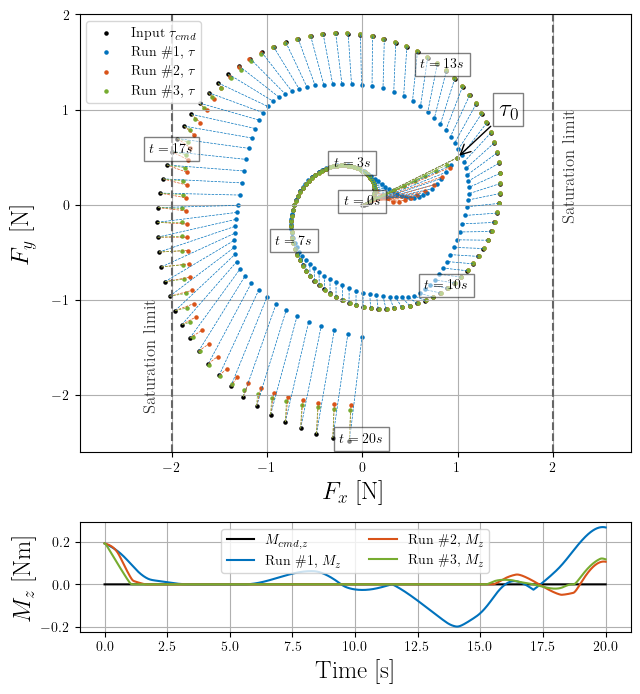

In [5]:
fig, ax = nice_plot_2d_allocation(tau_cmd=tau_cmd, allocators=allocators, tau_hist=results.tau_desired_hist, dt=time_step)
fig.tight_layout(pad=0.3)

fig.set_size_inches(6.5, 7)

legend_items = []
legend_items.append(r"Input $\tau_{cmd}$")
for i in range(len(gamma)):
    legend_items.append(f"Run $\#{i + 1}$, $\\tau$")
ax[0].legend(legend_items)

legend_items = []
legend_items.append(r"$M_{cmd,z}$")
for i in range(len(gamma)):
    legend_items.append(f"Run $\#{i + 1}$, $M_z$")
ax[1].legend(legend_items, ncol=2)

ax[0].set_ylim(-2.6, 2)
ax[0].vlines(x=-2, ymin=-10, ymax=10, color="#666666", linestyle="--")
ax[0].vlines(x=2, ymin=-10, ymax=10, color="#666666", linestyle="--")
ax[0].text(
    -2.3,
    -1,
    "Saturation limit",
    color="#333333",
    va="top",
    ha="left",
    fontsize=12,
    rotation=90,
)
ax[0].text(
    2.1,
    1,
    "Saturation limit",
    color="#333333",
    va="top",
    ha="left",
    fontsize=12,
    rotation=90,
)



# ax[0].text(0, 0, '$t=0$s', fontsize = 12, bbox = dict(facecolor = 'white', alpha = 0.7))
fig.align_labels()
# fig.savefig("plots/100_shell.pdf", bbox_inches='tight')
# fig.savefig("plots/100_shell.svg", bbox_inches='tight')

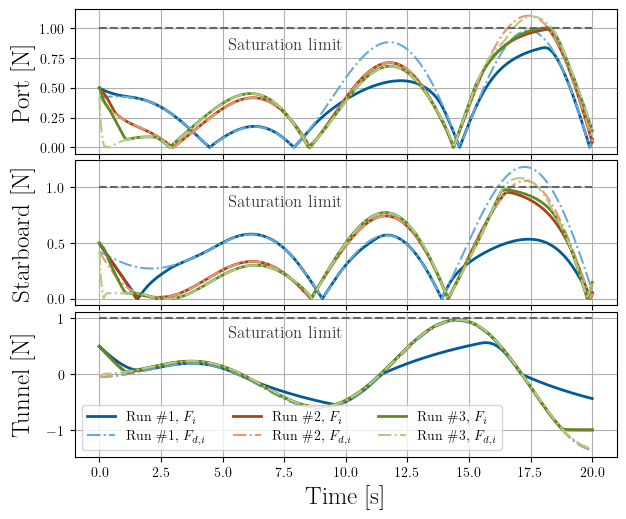

In [6]:
fig, ax = nice_plot_thruster_forces_reference_filter(
    results.xi_out_hist, results.xi_desired_hist, dt=time_step
)
fig.tight_layout(pad=0.0)

for i, plot in enumerate(ax[0:2]):
    plot.hlines(y=1, xmin=0, xmax=20, color="#666666", linestyle="--")
    plot.text(
        5.2,
        0.80,
        "Saturation limit",
        color="#333333",
        va="bottom",
        ha="left",
        fontsize=12,
    )

ax[-1].hlines(y=1, xmin=0, xmax=20, color="#666666", linestyle="--")
ax[-1].text(
    5.2,
    0.6,
    "Saturation limit",
    color="#333333",
    va="bottom",
    ha="left",
    fontsize=12,
)



ax[-1]
legend_items = []
for j, z in enumerate(zeta):
    legend_items.append(f"Run $\#{j + 1}$, $F_i$")
    legend_items.append(f"Run $\#{j + 1}$, $F_{{d,i}}$")


# legend_items.append(r"$F_{max}$")
ax[-1].legend(legend_items, loc="best", ncol=3)
fig.align_labels()
# fig.savefig("plots/100_thruster_forces.pdf", bbox_inches="tight")
# fig.savefig("plots/100_thruster_forces.svg", bbox_inches="tight")

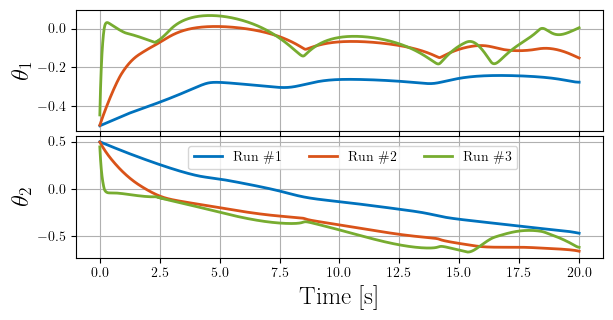

In [7]:
fig, ax = nice_plot_theta_histories(results.theta_hist, dt=time_step)
fig.tight_layout(pad=0.0)

l = []
for i in range(len(gamma)):
    l.append(f"Run $\#{i + 1}$")

ax[-1].legend(l, ncol=len(gamma), bbox_to_anchor=(0.2,0.67))
fig.align_labels()
# fig.savefig("plots/100_theta.pdf", bbox_inches='tight')
# fig.savefig("plots/100_theta.svg", bbox_inches='tight')

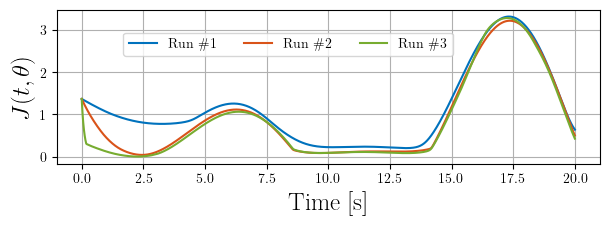

In [8]:
no_actuator = 0
no_allocator = 0

actuator_0_idx = 0
actuator_1_idx = 1
actuator_2_idx = 3

actuator_idx = actuator_2_idx

def cost_P(n_al, n_ac):

    ac_idxs = [0, 1, 3]

    z1 = np.linalg.norm(results.xi_desired_hist[n_al][:,ac_idxs[n_ac]:ac_idxs[n_ac]+2], axis=1)
    a_ref = actuators[n_ac].extra_attributes['reference_angle']
    a = np.array([np.cos(a_ref), np.sin(a_ref)])
    results.xi_desired_hist[n_al][:,ac_idxs[n_ac]:ac_idxs[n_ac]+2]

    z2 = np.empty_like(z1)

    for i in range(len(z1)):
        z2[i] = allocators[n_al]._lambda * ( a.T @ results.xi_desired_hist[n_al][i,ac_idxs[n_ac]:ac_idxs[n_ac]+2])

    return (P := z1-z2)

colors = [
    "#0072BD",
    "#D95319",
    "#77AC30",
    "#7E2F8E",
    "#4DBEEE",
    "#EDB120",
    "#A2142F",
    "#77AC30",
    "#4DBEEE",
    "#A2142F",
]

P = cost_P(2, 2)
fig = plt.figure()
plt.plot(np.linspace(0,20, len(P)), cost_P(0,1) + cost_P(0, 2),'-', color=colors[0])
plt.plot(np.linspace(0,20, len(P)), cost_P(1,1) + cost_P(1, 2),'-', color=colors[1])
plt.plot(np.linspace(0,20, len(P)), cost_P(1,1) + cost_P(2, 2),'-', color=colors[2])
# plt.plot(np.linspace(0,20, len(P)), cost_P(0,2),'--', color=colors[0])
# plt.plot(np.linspace(0,20, len(P)), cost_P(1,1),'-', color=colors[1])
# plt.plot(np.linspace(0,20, len(P)), cost_P(1,2),'--', color=colors[1])
# plt.plot(np.linspace(0,20, len(P)), cost_P(2,1),'-', color=colors[2])
# plt.plot(np.linspace(0,20, len(P)), cost_P(2,2), '--',color=colors[2])

plt.grid(True)
fig.set_size_inches(7,2)
l = []
for i in range(len(gamma)):
    l.append(f"Run $\#{i + 1}$")

fig.legend(l, ncol=len(gamma), bbox_to_anchor=(0.7, 0.8))
plt.ylabel("$J(t,\\theta)$")
plt.xlabel("Time [s]")
fig.savefig("plots/100_cost_function.svg", bbox_inches='tight')

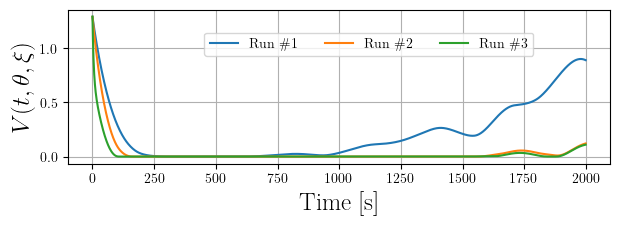

In [9]:
fig = plt.figure()
for i in range(len(results.xi_desired_hist)):
    a = np.power(np.linalg.norm(results.xi_desired_hist[i] - results.xi_out_hist[i], axis=1),2)
    plt.plot(a)

plt.grid(True)
fig.set_size_inches(7,2)
l = []
for i in range(len(gamma)):
    l.append(f"Run $\#{i + 1}$")



fig.legend(l, ncol=len(gamma), bbox_to_anchor=(0.8, 0.8))
plt.ylabel("$V(t,\\theta,\\xi)$")
plt.xlabel("Time [s]")

fig.savefig("plots/100_lyapunov.svg", bbox_inches='tight')